# Analyze Tornado Data with Python and GeoPandas  
**Insights from NOAA's Public Domain Database**

Adpted from *Lee Vaughan*   

In this notebook we analyze tornado data reported from 1950 to 2023 using Python. We load NOAA’s CSV data, create geospatial data with GeoPandas, map the tornado start locations on U.S. state and county boundaries (using pygris for Census boundaries), and produce several charts (with Matplotlib and Plotly Express) to study tornado frequencies, magnitudes, and fatalities.


In [ ]:
# Import necessary libraries
%pip install pygris
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, box
from pygris import states, counties


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 32.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Loading Data and Creating the Tornado GeoDataFrame

We load the NOAA tornado CSV (hosted on a Gist for convenience), filter out non-contiguous states (Alaska, Hawaii, Puerto Rico, Virgin Islands), and create a GeoDataFrame using the tornado start locations (slon, slat). We also remove rows where the tornado magnitude is unknown (represented by -9).


In [3]:
# Load the CSV file into a DataFrame 
df_raw = pd.read_csv('https://bit.ly/40xJCMK')

# Filter out Alaska, Hawaii, Puerto Rico, and Virgin Islands
df = df_raw[~df_raw['st'].isin(['AK', 'HI', 'PR', 'VI'])]

# Create a GeoDataFrame for the tornado start locations using slon and slat columns
geometry = [Point(xy) for xy in zip(df['slon'], df['slat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Filter out rows where magnitude is -9 (unknown)
gdf = gdf[gdf['mag'] != -9]

# Show the first few rows of the GeoDataFrame
gdf.head()


,om,yr,mo,dy,date,time,tz,st,stf,stn,...,wid,ns,sn,sg,f1,f2,f3,f4,fc,geometry
0,192,1950,10,1,10/1/1950,21:00:00,3,OK,40,23,...,10,1,1,1,25,0,0,0,0,POINT (-102.52 36.73)
1,193,1950,10,9,10/9/1950,2:15:00,3,NC,37,9,...,880,1,1,1,47,0,0,0,0,POINT (-78.6 34.17)
2,195,1950,11,20,11/20/1950,2:20:00,3,KY,21,1,...,10,1,1,1,177,0,0,0,0,POINT (-87.2 37.37)
3,196,1950,11,20,11/20/1950,4:00:00,3,KY,21,2,...,10,1,1,1,209,0,0,0,0,POINT (-84.5 38.2)
4,197,1950,11,20,11/20/1950,7:30:00,3,MS,28,14,...,37,1,1,1,101,0,0,0,0,POINT (-89.13 32.42)


## Checking Unknown Magnitude Count

Let's count the number of tornado records with magnitude -9 before filtering.


In [4]:
num_negative_nines = (df['mag'] == -9).sum()
print(f"Number of -9 values in the 'mag' column: {num_negative_nines}")


Number of -9 values in the 'mag' column: 1024


## Preparing County and State Boundaries with pygris

We use the pygris package to load U.S. Census Bureau TIGER/Line state and county boundaries, filter to the contiguous U.S., and clip to a bounding box covering the Lower 48.

In [5]:
# Load state boundaries from pygris (year=2020)
states_df = states(year=2020)
states_gdf = gpd.GeoDataFrame(states_df)

# Load county boundaries from pygris (year=2020)
counties_df = counties(year=2020)
counties_gdf = gpd.GeoDataFrame(counties_df)

# Filter for contiguous US (exclude AK, HI, PR, VI)
states_gdf = states_gdf[~states_gdf['STUSPS'].isin(['AK', 'HI', 'PR', 'VI'])]
counties_gdf = counties_gdf[~counties_gdf['STATEFP'].isin(['02', '15', '72', '78'])]  # FIPS for AK, HI, PR, VI

# Create a bounding box for the contiguous US
bounds_box = box(-127, 23, -67, 50)  # (min_lon, min_lat, max_lon, max_lat)

# Clip the state and county GeoDataFrames to the bounding box
clipped_states = gpd.clip(states_gdf, bounds_box)
clipped_counties = gpd.clip(counties_gdf, bounds_box)


## Plotting All Tornadoes (1950-2023) on U.S. Boundaries

We now create a static map using Matplotlib. The U.S. counties and state borders are plotted first as a base layer; then the tornado start locations are overlaid.


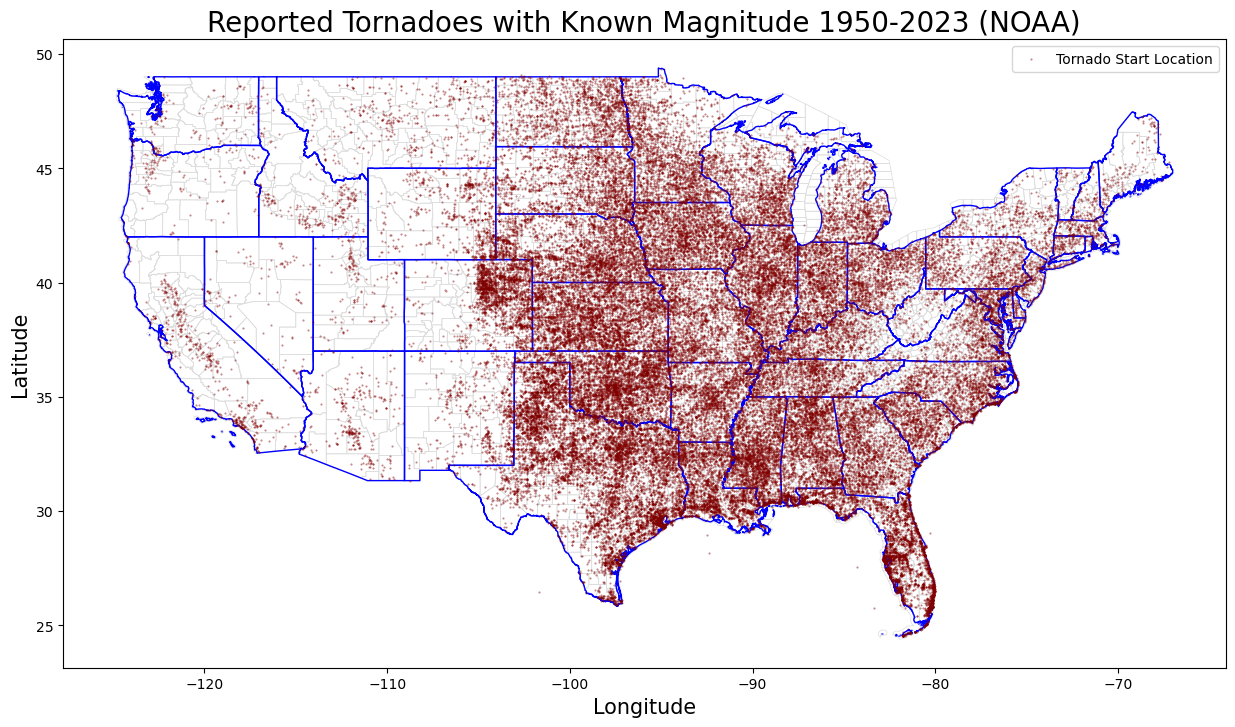

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Plot county and state boundaries
clipped_counties.plot(ax=ax, color='none', edgecolor='gainsboro', linewidth=0.5)
clipped_states.plot(ax=ax, color='none', edgecolor='blue', linewidth=1)

# Plot tornado start locations (points)
gdf.plot(ax=ax, color='maroon', marker='.', markersize=1, alpha=0.5, label='Tornado Start Location')

plt.title('Reported Tornadoes with Known Magnitude 1950-2023 (NOAA)', fontsize=20)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.legend()
plt.show()


## Mapping 2023 Tornadoes

Next, we filter the GeoDataFrame to only include tornadoes from 2023 and plot them on the same U.S. boundaries.


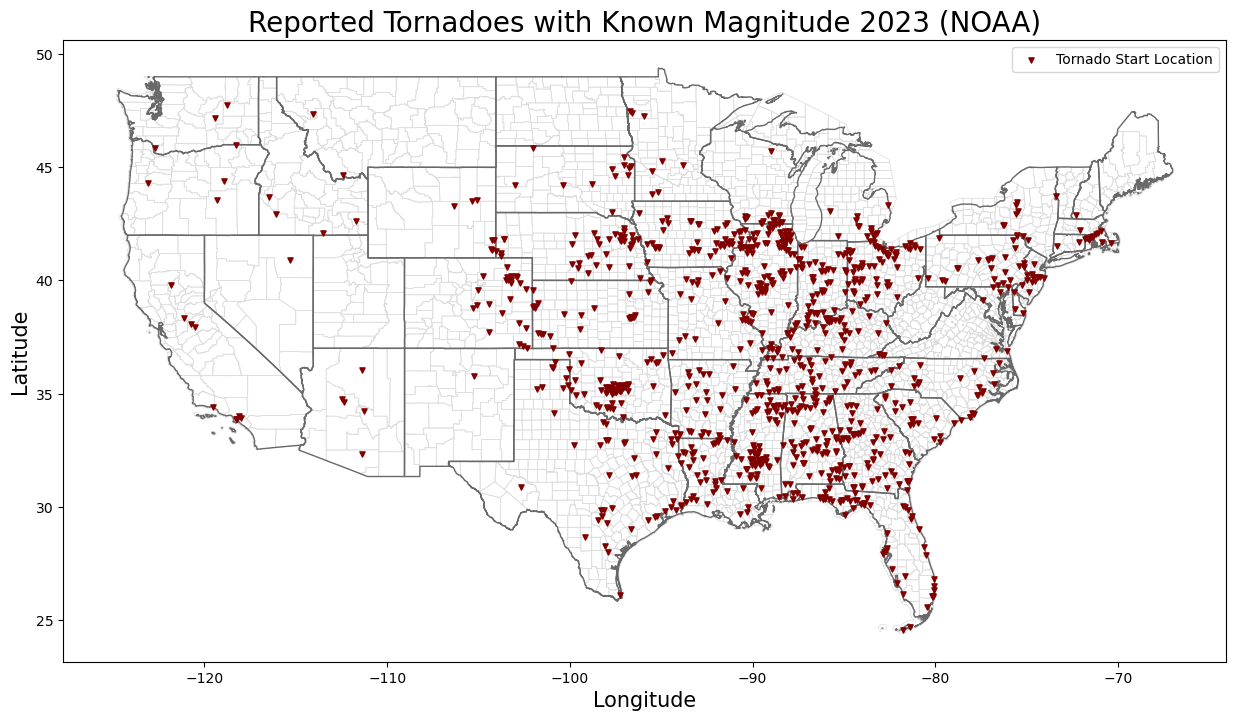

In [7]:
# Filter tornado data for the year 2023
gdf_2023 = gdf[gdf['yr'] == 2023].copy()

fig, ax = plt.subplots(1, 1, figsize=(15, 12))
clipped_counties.plot(ax=ax, color='none', edgecolor='gainsboro', linewidth=0.5)
clipped_states.plot(ax=ax, color='none', edgecolor='dimgrey', linewidth=1)

# Use an inverted triangle marker ('v') to represent tornado start locations
gdf_2023.plot(ax=ax, color='maroon', marker='v', markersize=14, label='Tornado Start Location')

plt.title('Reported Tornadoes with Known Magnitude 2023 (NOAA)', fontsize=20)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.legend()
plt.show()


## Mapping 2023 Tornadoes by EF Magnitude

We now separate the tornadoes by magnitude (EF0–1 vs. EF2+) and plot them in different colors.


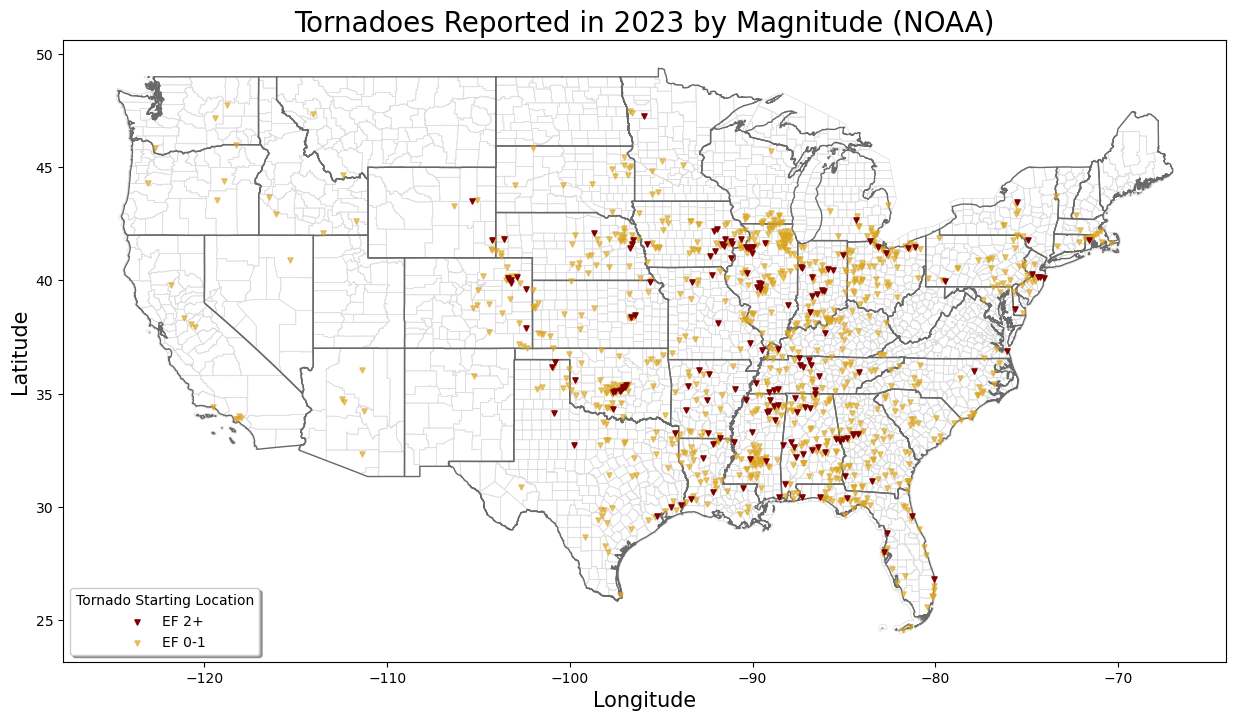

In [ ]:
# Create a copy of the 2023 GeoDataFrame
gdf_2023_colors = gdf_2023.copy()

fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Plot county and state boundaries
clipped_counties.plot(ax=ax, color='none', edgecolor='gainsboro', linewidth=0.5, zorder=1)
clipped_states.plot(ax=ax, color='none', edgecolor='dimgrey', linewidth=1, zorder=2)

# Plot EF2+ tornadoes in maroon
gdf_2023_colors[gdf_2023_colors['mag'] >= 2].plot(ax=ax,
                                                  color='maroon',
                                                  marker='v',
                                                  markersize=14,
                                                  zorder=4,
                                                  label='EF 2+')

# Plot EF0-1 tornadoes in goldenrod
gdf_2023_colors[gdf_2023_colors['mag'] <= 1].plot(ax=ax,
                                                  color='goldenrod',
                                                  alpha=0.6,
                                                  marker='v',
                                                  markersize=14,
                                                  zorder=3,
                                                  label='EF 0-1')

plt.title('Tornadoes Reported in 2023 by Magnitude (NOAA)', fontsize=20)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.legend(loc='lower left', title="Tornado Starting Location", shadow=True, fancybox=True)
plt.show()


## Bonus: Interactive Map with Plotly Express

For an interactive mapping experience, we use Plotly Express. This cell loads the CSV again and plots 2023 tornadoes with hover information.


In [12]:
import plotly.express as px
from IPython.display import display

# Load the CSV file into a DataFrame
df_raw = pd.read_csv('https://bit.ly/40xJCMK')
df_plotly = df_raw[df_raw['mag'] != -9]  # filter out unknown magnitudes

# Filter for tornadoes in 2023
df_2023_plotly = df_plotly[df_plotly['yr'] == 2023].copy()

# Convert 'mag' to string for discrete color mapping (if desired)
df_2023_plotly['mag'] = df_2023_plotly['mag'].astype(object)

# Define a discrete color scale
color_scale = px.colors.qualitative.Set1

# Create the interactive scatter_geo plot,
# ensuring the size parameter is a numeric list.
fig = px.scatter_geo(
    df_2023_plotly,
    lat='slat',
    lon='slon',
    color='mag',  # Color points by tornado magnitude
    size=df_2023_plotly['mag'].astype(float).tolist(),
    size_max=12,
    hover_name='st',  # state abbreviation
    hover_data={'yr': True, 'mag': True, 'fat': True},
    title="Tornadoes Reported in 2023 (NOAA)",
    scope="usa",
    projection="albers usa",
    labels={'mag': 'Magnitude'},
    color_discrete_sequence=color_scale
)

# Customize layout for a better display
fig = px.scatter_geo(
    df_2023_plotly,
    lat='slat',
    lon='slon',
    color='mag',  # Color points by tornado magnitude
    size=df_2023_plotly['mag'].astype(float).tolist(),
    size_max=12,
    hover_name='st',  # state abbreviation
    hover_data={'yr': True, 'mag': True, 'fat': True},
    title="Tornadoes Reported in 2023 (NOAA)",
    scope="usa",
    projection="albers usa",
    labels={'mag': 'Magnitude'},
    color_discrete_sequence=color_scale,
    category_orders={'mag': [0, 1, 2, 3, 4]}  # enforce numeric order
)


# Use an upside-down triangle to resemble tornadoes
fig.update_traces(marker=dict(symbol="triangle-down"))

# Display the interactive map
display(fig)


## Charting: Number of Tornadoes per Year

We now create a bar chart of tornado counts per year (including those with unknown magnitudes) to examine long-term trends.


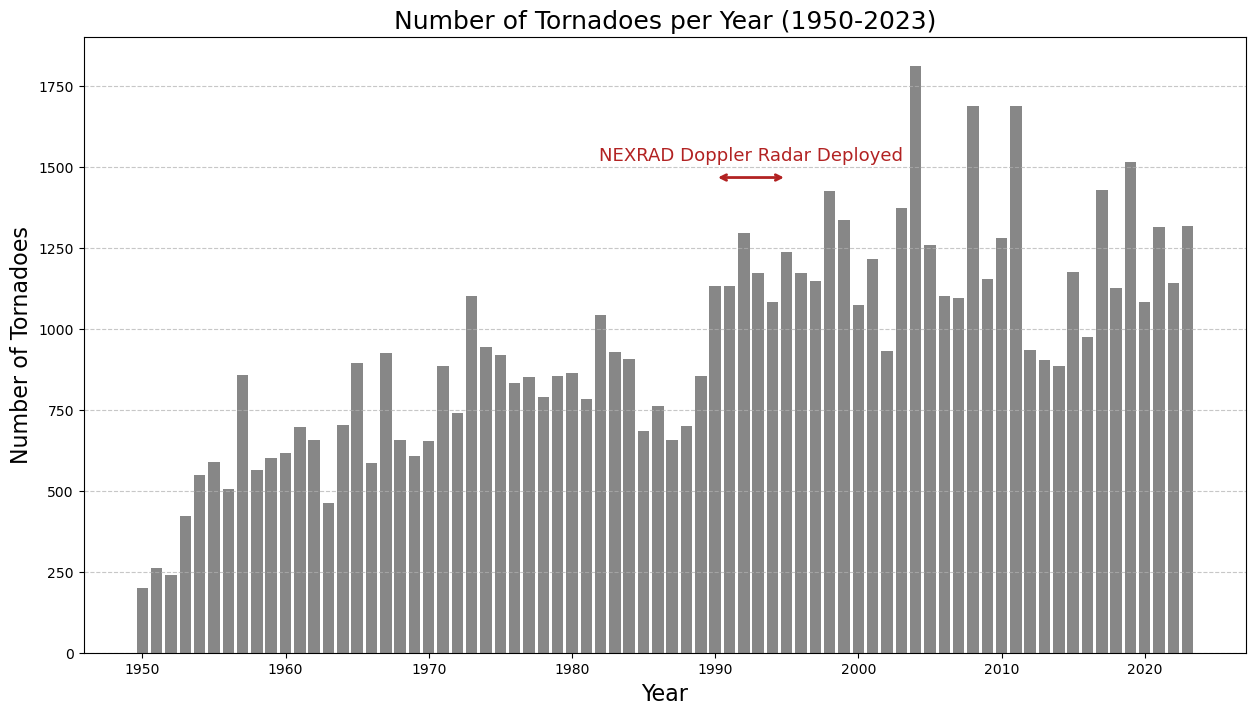

In [13]:
# Reload the CSV for charting and filter out non-contiguous states
df_chart = pd.read_csv('https://bit.ly/40xJCMK')
df_chart = df_chart[~df_chart['st'].isin(['AK', 'HI', 'PR', 'VI'])]

# Group by year and count tornado occurrences
tornadoes_per_year = df_chart.groupby('yr').size()

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(tornadoes_per_year.index, tornadoes_per_year.values, color='dimgrey', alpha=0.8)

# Highlight the period 1990-1995 (when NEXRAD Doppler radar was deployed)
start_year = 1990
end_year = 1995
y_position = tornadoes_per_year.max() * 0.81

ax.annotate('', 
            xy=(end_year, y_position), 
            xytext=(start_year, y_position),
            arrowprops=dict(arrowstyle='<->', color='firebrick', lw=2))

ax.text((start_year + end_year) / 2,
        y_position + tornadoes_per_year.max() * 0.03,
        "NEXRAD Doppler Radar Deployed", 
        color='firebrick', fontsize=13, ha='center')

ax.set_title('Number of Tornadoes per Year (1950-2023)', fontsize=18)
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Number of Tornadoes', fontsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


## Charting: Number of Tornadoes per Month

This chart shows the monthly frequency of tornadoes. We add a column for month abbreviations and create a bar chart.


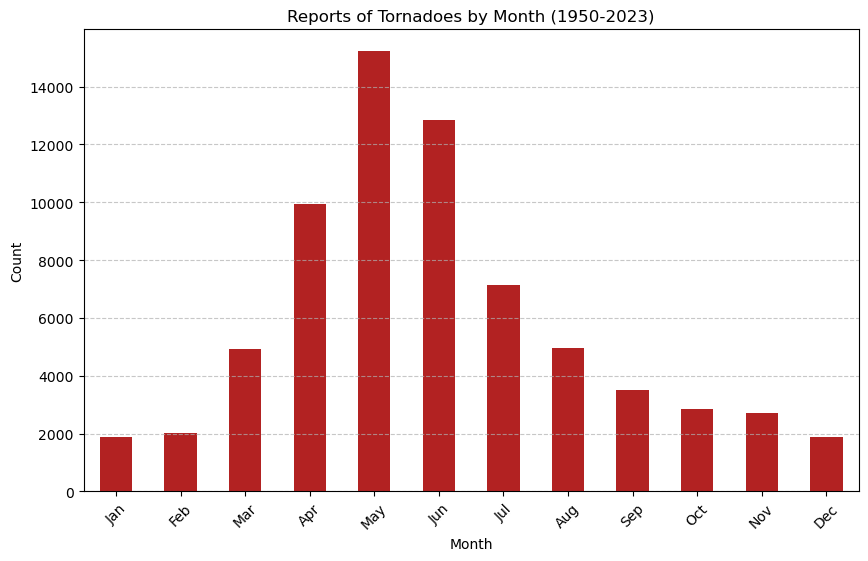

In [14]:
# Create a month abbreviation column
df_chart['month_abbr'] = df_chart['mo'].apply(lambda x: calendar.month_abbr[x])

# Reorder months (from Jan to Dec) and plot the counts
df_chart['month_abbr'].value_counts().reindex(calendar.month_abbr[1:]).plot(
    kind='bar',
    color='firebrick',
    figsize=(10, 6),
    xlabel='Month',
    ylabel='Count',
    title='Reports of Tornadoes by Month (1950-2023)'
)

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Charting: Annual Cumulative Tornado Counts vs. Month

We compute cumulative counts per month for each year and compare recent years (2009–2023) with the overall mean.


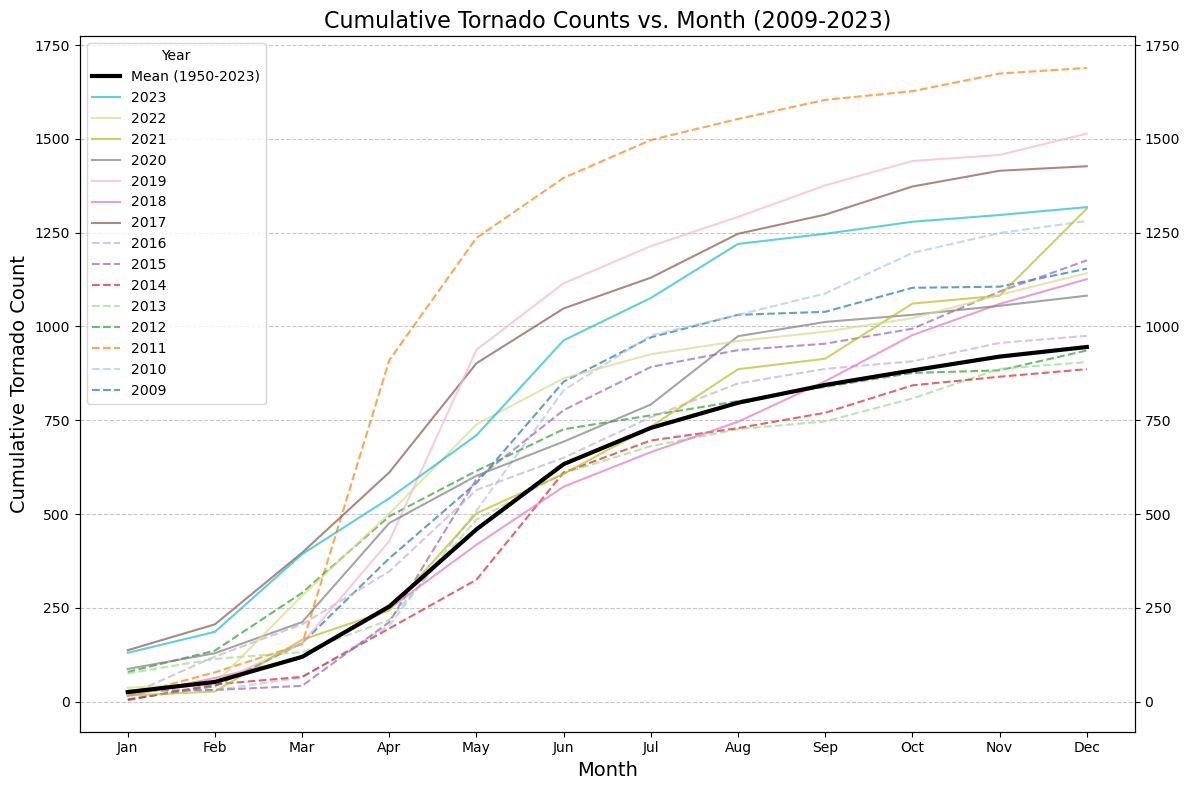

In [15]:
# Reload the CSV for cumulative plots
df_cum = pd.read_csv('https://bit.ly/40xJCMK')
df_cum = df_cum[~df_cum['st'].isin(['AK', 'HI', 'PR', 'VI'])]

def prepare_data(df, start_year=None, end_year=None):
    if start_year and end_year:
        df = df[(df['yr'] >= start_year) & (df['yr'] <= end_year)]
    grouped = df.groupby(['yr', 'mo']).size().reset_index(name='tornado_count')
    pivot = grouped.pivot(index='mo', columns='yr', values='tornado_count').fillna(0)
    return pivot.cumsum()

# Cumulative sums for all years and the mean per month
cumulative_all_years = prepare_data(df_cum)
mean_all_years = cumulative_all_years.mean(axis=1)

# Cumulative counts for 2009-2023
cumulative_counts = prepare_data(df_cum, start_year=2009, end_year=2023)

fig, ax = plt.subplots(figsize=(12, 8))
cmap = plt.cm.tab20

# Plot each year's cumulative count with different linestyles
for idx, year in enumerate(cumulative_counts.columns):
    linestyle = 'dashed' if 2009 <= year <= 2016 else 'solid'
    ax.plot(cumulative_counts.index, cumulative_counts[year],
            label=str(year),
            color=cmap(idx / len(cumulative_counts.columns)),
            linestyle=linestyle,
            alpha=0.7)

# Plot the overall mean cumulative count
ax.plot(mean_all_years.index, mean_all_years, color='k', linewidth=3, label='Mean (1950-2023)')

def customize_plot(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.grid(axis='y', linestyle='--', alpha=0.7)

customize_plot(ax=ax,
               title='Cumulative Tornado Counts vs. Month (2009-2023)',
               xlabel='Month',
               ylabel='Cumulative Tornado Count')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', fontsize=10, title="Year")

# Mirror the y-axis on the right side for clarity
ax2 = ax.twinx()
ax2.set_yticks(ax.get_yticks())
ax2.set_ylim(ax.get_ylim())
ax2.set_yticklabels([int(label) for label in ax.get_yticks()])

plt.tight_layout()
plt.show()


## Charting: Number of Tornadoes by EF Magnitude

Here we count the number of tornadoes per EF magnitude (with -9 representing unknown magnitude) and create a bar chart with annotations.


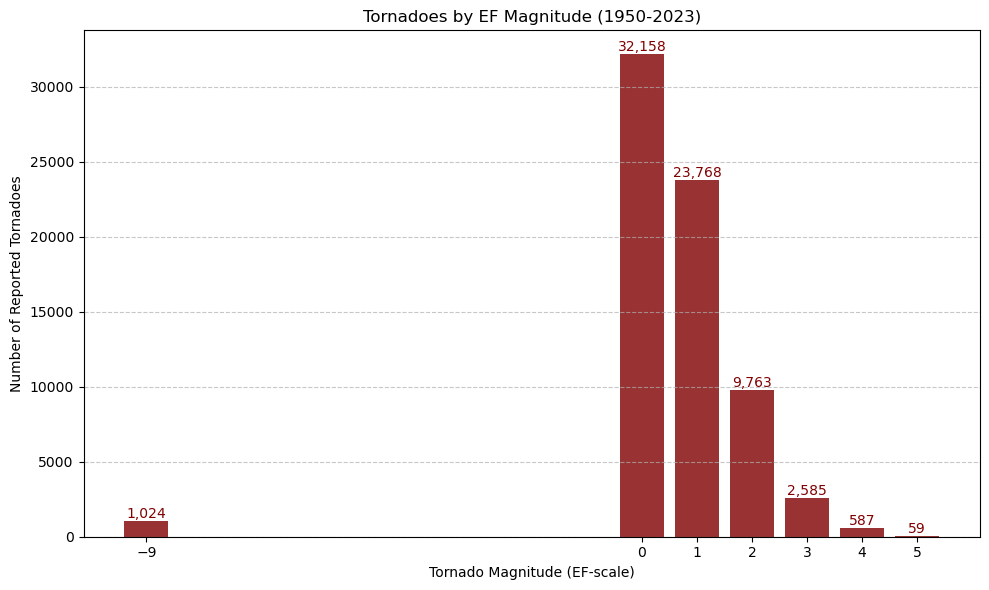

In [16]:
magnitude_counts = df_chart['mag'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(magnitude_counts.index, magnitude_counts.values, color='maroon', alpha=0.8)

# Annotate each bar with the count
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
             height + 5,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=10, color='maroon')

plt.xlabel('Tornado Magnitude (EF-scale)')
plt.ylabel('Number of Reported Tornadoes')
plt.title('Tornadoes by EF Magnitude (1950-2023)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([-9, 0, 1, 2, 3, 4, 5])
plt.tight_layout()
plt.show()


## Charting: Total Fatalities by EF Magnitude

This chart shows the total number of fatalities for tornadoes by their EF magnitude.


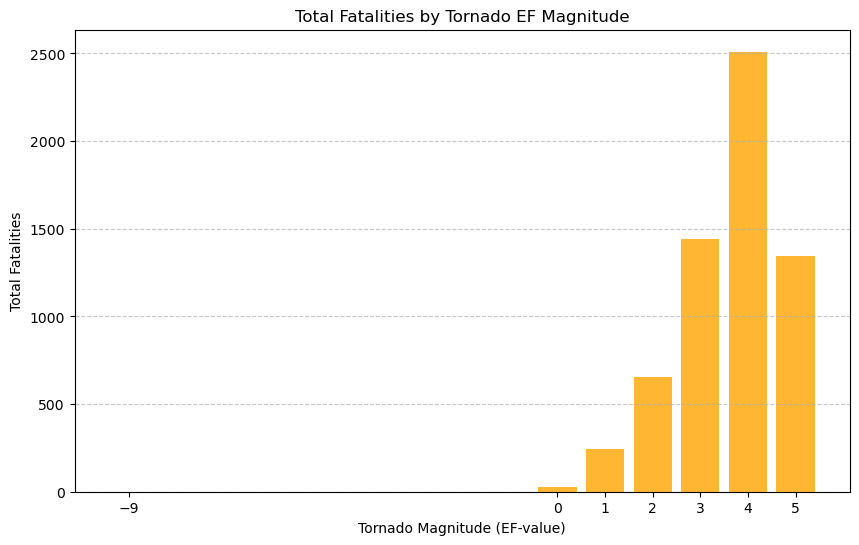

In [17]:
fatalities_by_magnitude = df_chart.groupby('mag')['fat'].sum()

plt.figure(figsize=(10, 6))
plt.bar(fatalities_by_magnitude.index, fatalities_by_magnitude.values, color='orange', alpha=0.8)
plt.xlabel('Tornado Magnitude (EF-value)')
plt.ylabel('Total Fatalities')
plt.title('Total Fatalities by Tornado EF Magnitude')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([-9, 0, 1, 2, 3, 4, 5])
plt.show()


## Conclusion

In this notebook we used free NOAA tornado data to analyze and map tornado occurrences from 1950 to 2023. We:
- Loaded and prepared the tornado data as a GeoDataFrame.
- Retrieved U.S. state and county boundaries with pygris and clipped them to the contiguous U.S.
- Plotted static maps of all tornadoes and subsets (e.g., for 2023, by EF magnitude) using Matplotlib and GeoPandas.
- Created interactive maps with Plotly Express.
- Built charts to analyze annual and monthly tornado frequencies, cumulative counts, EF magnitude distributions, and fatalities by tornado strength.

Feel free to explore further and modify the code to answer your own questions about tornado climatology!
